# STA365 Homework 4

### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

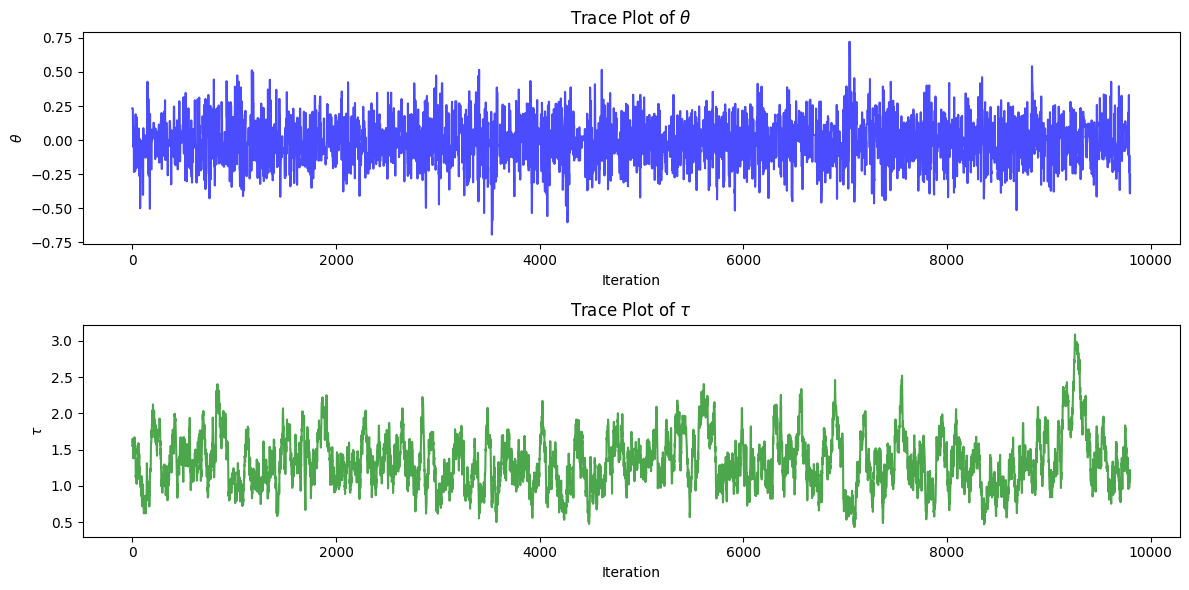

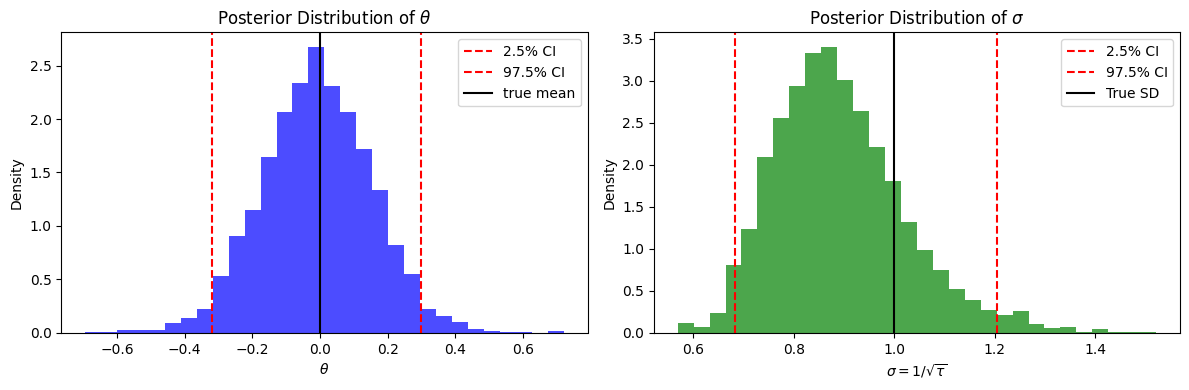

Theta credible interval: [-0.32063834  0.30031333]
Tau (converted to sigma) credible interval: [0.68311172 1.20515778]


In [12]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Set parameters
n = 30
m = 0
s = 1
np.random.seed(365)
x = stats.norm(loc=m, scale=s).rvs(size=n)

C, G = 2, 10000  # Number of chains and iterations
theta, tau = np.zeros((C, G)), np.zeros((C, G))
theta[:, 0] = np.mean(x)  # Initialize theta close to sample mean
tau[:, 0] = 1 / np.var(x)  # Initialize tau close to sample precision
alpha, lambda_ = 2, 2  # Prior hyperparameters

# Proposal standard deviations
theta_proposal_sd = 0.5  
tau_proposal_sd = 0.1  

# Metropolis within Gibbs Sampling
for c in range(C):
    for g in range(1, G):
        # 1. Metropolis step for theta
        theta_candidate = stats.norm(loc=theta[c, g - 1], scale=theta_proposal_sd).rvs()
        
        # Compute the acceptance ratio (log-scale for stability)
        log_posterior_current = (
            np.sum(stats.norm.logpdf(x, loc=theta[c, g - 1], scale=1 / np.sqrt(tau[c, g - 1])))
            + stats.norm.logpdf(theta[c, g - 1], loc=m, scale=s)
        )
        log_posterior_candidate = (
            np.sum(stats.norm.logpdf(x, loc=theta_candidate, scale=1 / np.sqrt(tau[c, g - 1])))
            + stats.norm.logpdf(theta_candidate, loc=m, scale=s)
        )
        
        log_alpha = log_posterior_candidate - log_posterior_current
        if np.log(np.random.rand()) < log_alpha:
            theta[c, g] = theta_candidate  # Accept
        else:
            theta[c, g] = theta[c, g - 1]  # Reject, keep previous value
        
        # 2. Metropolis step for tau (ensuring positivity)
        tau_candidate = abs(stats.norm(loc=tau[c, g - 1], scale=tau_proposal_sd).rvs())  # Using absolute value to keep positive
        
        log_posterior_current = (
            np.sum(stats.norm.logpdf(x, loc=theta[c, g], scale=1 / np.sqrt(tau[c, g - 1])))
            + stats.gamma.logpdf(tau[c, g - 1], a=alpha/2, scale=2/lambda_)
        )
        log_posterior_candidate = (
            np.sum(stats.norm.logpdf(x, loc=theta[c, g], scale=1 / np.sqrt(tau_candidate)))
            + stats.gamma.logpdf(tau_candidate, a=alpha/2, scale=2/lambda_)
        )
        
        log_alpha = log_posterior_candidate - log_posterior_current
        if np.log(np.random.rand()) < log_alpha:
            tau[c, g] = tau_candidate  # Accept
        else:
            tau[c, g] = tau[c, g - 1]  # Reject, keep previous value

# Burn-in period
burn = 200

# Compute Bayesian credible intervals
theta_samples = theta[0, burn:]
tau_samples = tau[0, burn:]

theta_ci = np.quantile(theta_samples, [0.025, 0.975])
tau_ci = np.quantile(1 / np.sqrt(tau_samples), [0.025, 0.975])

# Compute means
theta_mean = np.mean(theta_samples)
tau_mean = np.mean(1 / np.sqrt(tau_samples))

# Trace plots for theta and tau
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Trace plot for theta
ax[0].plot(theta[0, burn:], color='blue', alpha=0.7)
ax[0].set_title("Trace Plot of $\\theta$")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("$\\theta$")

# Trace plot for tau
ax[1].plot(tau[0, burn:], color='green', alpha=0.7)
ax[1].set_title("Trace Plot of $\\tau$")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("$\\tau$")

plt.tight_layout()
plt.show()

# Plot histograms with credible intervals
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Theta histogram
ax[0].hist(theta_samples, bins=30, density=True, alpha=0.7, color='blue')
ax[0].axvline(theta_ci[0], color='red', linestyle='dashed', label="2.5% CI")
ax[0].axvline(theta_ci[1], color='red', linestyle='dashed', label="97.5% CI")
ax[0].axvline(m, color='black', linestyle='solid', label="true mean")
ax[0].set_title("Posterior Distribution of $\\theta$")
ax[0].set_xlabel("$\\theta$")
ax[0].set_ylabel("Density")
ax[0].legend()

# Tau (converted to standard deviation) histogram
ax[1].hist(1 / np.sqrt(tau_samples), bins=30, density=True, alpha=0.7, color='green')
ax[1].axvline(tau_ci[0], color='red', linestyle='dashed', label="2.5% CI")
ax[1].axvline(tau_ci[1], color='red', linestyle='dashed', label="97.5% CI")
ax[1].axvline(s, color='black', linestyle='solid', label="True SD")
ax[1].set_title("Posterior Distribution of $\\sigma$")
ax[1].set_xlabel("$\\sigma = 1 / \\sqrt{\\tau}$")
ax[1].set_ylabel("Density")
ax[1].legend()

plt.tight_layout()
plt.show()

# Print credible intervals
print("Theta credible interval:", theta_ci)
print("Tau (converted to sigma) credible interval:", tau_ci)

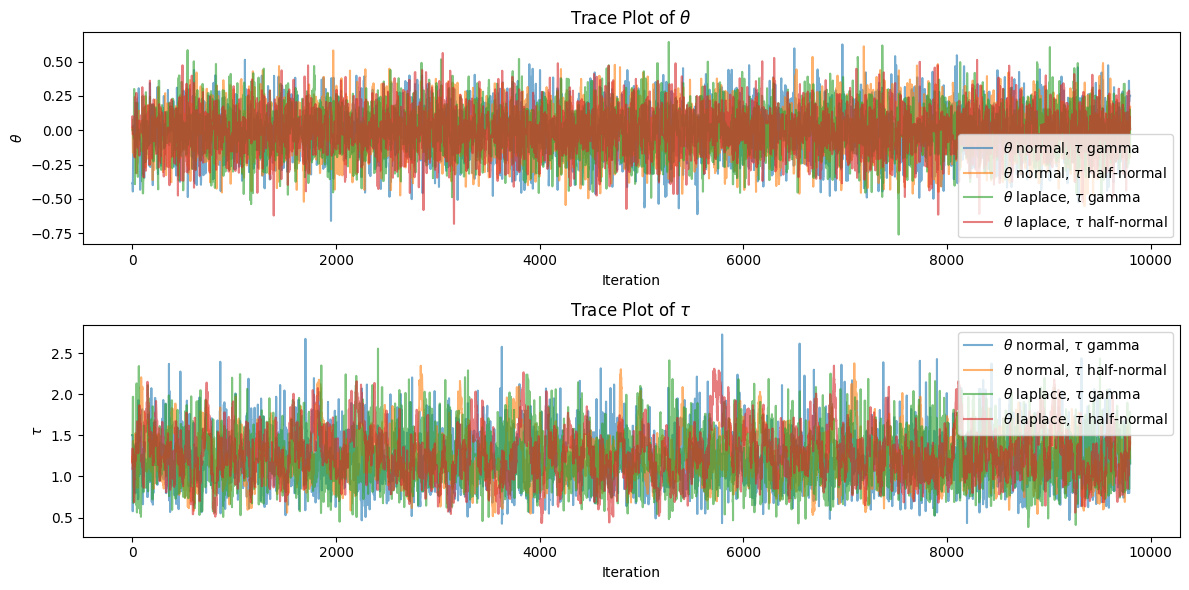

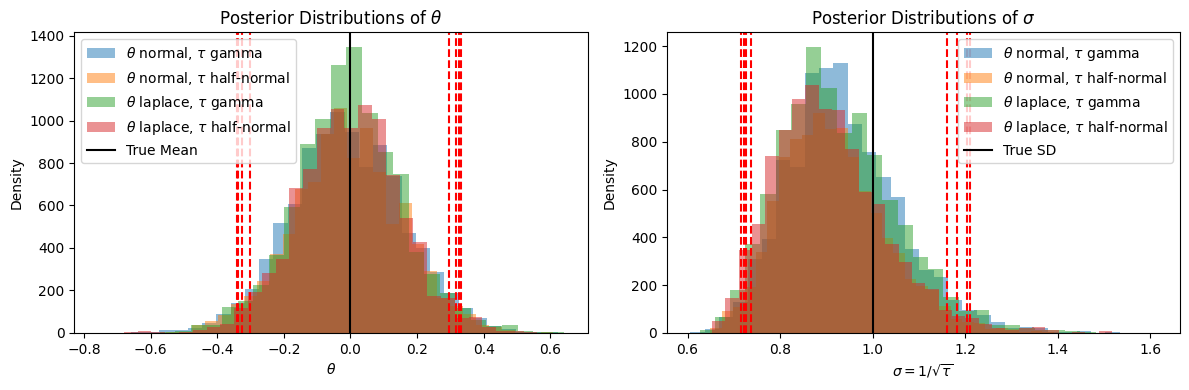

Theta credible interval ('normal', 'gamma'): [-0.33792826  0.32727903]
Theta credible interval ('normal', 'half-normal'): [-0.3401819  0.3183002]
Theta credible interval ('laplace', 'gamma'): [-0.3258671   0.33157539]
Theta credible interval ('laplace', 'half-normal'): [-0.30195005  0.29713404]
Sigma credible interval ('normal', 'gamma'): [0.7359489  1.20947678]
Sigma credible interval ('normal', 'half-normal'): [0.7260965  1.16074282]
Sigma credible interval ('laplace', 'gamma'): [0.72237455 1.20413097]
Sigma credible interval ('laplace', 'half-normal'): [0.71527678 1.18293869]


In [19]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Set parameters
n = 30
m = 0  # True mean
s = 1  # True standard deviation
np.random.seed(365)
x = stats.norm(loc=m, scale=s).rvs(size=n)

C, G = 2, 10000  # Chains and iterations
alpha, lambda_ = 2, 2  # Hyperparameters for Gamma prior

# Proposal standard deviations
theta_proposal_sd = 0.5  
tau_proposal_sd = 0.1  

# Different priors to compare
theta_priors = ['normal', 'laplace']
tau_priors = ['gamma', 'half-normal']

# Store results
theta_samples = {}
tau_samples = {}

# Run Metropolis within Gibbs for each prior combination
for theta_prior in theta_priors:
    for tau_prior in tau_priors:
        theta = np.zeros((C, G))
        tau = np.zeros((C, G))
        theta[:, 0] = np.mean(x)
        tau[:, 0] = 1 / np.var(x)

        for c in range(C):
            for g in range(1, G):
                # Metropolis step for theta
                theta_candidate = stats.norm(loc=theta[c, g - 1], scale=theta_proposal_sd).rvs()
                
                if theta_prior == 'normal':
                    log_prior_theta_current = stats.norm.logpdf(theta[c, g - 1], loc=0, scale=1)
                    log_prior_theta_candidate = stats.norm.logpdf(theta_candidate, loc=0, scale=1)
                elif theta_prior == 'laplace':
                    log_prior_theta_current = stats.laplace.logpdf(theta[c, g - 1], loc=0, scale=1)
                    log_prior_theta_candidate = stats.laplace.logpdf(theta_candidate, loc=0, scale=1)

                log_posterior_current = (
                    np.sum(stats.norm.logpdf(x, loc=theta[c, g - 1], scale=1 / np.sqrt(tau[c, g - 1])))
                    + log_prior_theta_current
                )
                log_posterior_candidate = (
                    np.sum(stats.norm.logpdf(x, loc=theta_candidate, scale=1 / np.sqrt(tau[c, g - 1])))
                    + log_prior_theta_candidate
                )

                log_alpha = log_posterior_candidate - log_posterior_current
                if np.log(np.random.rand()) < log_alpha:
                    theta[c, g] = theta_candidate
                else:
                    theta[c, g] = theta[c, g - 1]

                # Metropolis step for tau
                if tau_prior == 'gamma':
                    tau_candidate = stats.gamma(a=alpha/2, scale=2/lambda_).rvs()
                elif tau_prior == 'half-normal':
                    tau_candidate = abs(stats.norm(loc=tau[c, g - 1], scale=tau_proposal_sd).rvs())

                if tau_prior == 'gamma':
                    log_prior_tau_current = stats.gamma.logpdf(tau[c, g - 1], a=alpha/2, scale=2/lambda_)
                    log_prior_tau_candidate = stats.gamma.logpdf(tau_candidate, a=alpha/2, scale=2/lambda_)
                elif tau_prior == 'half-normal':
                    log_prior_tau_current = stats.halfnorm.logpdf(tau[c, g - 1], loc=0, scale=1)
                    log_prior_tau_candidate = stats.halfnorm.logpdf(tau_candidate, loc=0, scale=1)

                log_posterior_current = (
                    np.sum(stats.norm.logpdf(x, loc=theta[c, g], scale=1 / np.sqrt(tau[c, g - 1])))
                    + log_prior_tau_current
                )
                log_posterior_candidate = (
                    np.sum(stats.norm.logpdf(x, loc=theta[c, g], scale=1 / np.sqrt(tau_candidate)))
                    + log_prior_tau_candidate
                )

                log_alpha = log_posterior_candidate - log_posterior_current
                if np.log(np.random.rand()) < log_alpha:
                    tau[c, g] = tau_candidate
                else:
                    tau[c, g] = tau[c, g - 1]

        # Store posterior samples after burn-in
        burn = 200
        theta_samples[(theta_prior, tau_prior)] = theta[0, burn:]
        tau_samples[(theta_prior, tau_prior)] = tau[0, burn:]

# Convert tau to standard deviation (sigma)
sigma_samples = {key: 1 / np.sqrt(val) for key, val in tau_samples.items()}

# Compute Bayesian credible intervals
theta_ci = {key: np.quantile(val, [0.025, 0.975]) for key, val in theta_samples.items()}
sigma_ci = {key: np.quantile(val, [0.025, 0.975]) for key, val in sigma_samples.items()}

# Plot overlaid trace plots
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Trace plot for theta
for (theta_prior, tau_prior), samples in theta_samples.items():
    ax[0].plot(samples, alpha=0.6, label=f"$\\theta$ {theta_prior}, $\\tau$ {tau_prior}")
ax[0].set_title("Trace Plot of $\\theta$")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("$\\theta$")
ax[0].legend()

# Trace plot for tau
for (theta_prior, tau_prior), samples in tau_samples.items():
    ax[1].plot(samples, alpha=0.6, label=f"$\\theta$ {theta_prior}, $\\tau$ {tau_prior}")
ax[1].set_title("Trace Plot of $\\tau$")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("$\\tau$")
ax[1].legend()

plt.tight_layout()
plt.show()

# Overlaid histograms of posterior distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Overlay histograms for theta
for (theta_prior, tau_prior), samples in theta_samples.items():
    ax[0].hist(samples, bins=30, alpha=0.5, label=f"$\\theta$ {theta_prior}, $\\tau$ {tau_prior}")
ax[0].axvline(m, color='black', linestyle='solid', label="True Mean")
for (theta_prior, tau_prior), ci in theta_ci.items():
    ax[0].axvline(ci[0], color='red', linestyle='dashed')
    ax[0].axvline(ci[1], color='red', linestyle='dashed')
ax[0].set_title("Posterior Distributions of $\\theta$")
ax[0].set_xlabel("$\\theta$")
ax[0].set_ylabel("Density")
ax[0].legend()

# Overlay histograms for sigma
for (theta_prior, tau_prior), samples in sigma_samples.items():
    ax[1].hist(samples, bins=30, alpha=0.5, label=f"$\\theta$ {theta_prior}, $\\tau$ {tau_prior}")
ax[1].axvline(s, color='black', linestyle='solid', label="True SD")
for (theta_prior, tau_prior), ci in sigma_ci.items():
    ax[1].axvline(ci[0], color='red', linestyle='dashed')
    ax[1].axvline(ci[1], color='red', linestyle='dashed')
ax[1].set_title("Posterior Distributions of $\\sigma$")
ax[1].set_xlabel("$\\sigma = 1 / \\sqrt{\\tau}$")
ax[1].set_ylabel("Density")
ax[1].legend()

plt.tight_layout()
plt.show()

# Print credible intervals
for key, ci in theta_ci.items():
    print(f"Theta credible interval {key}:", ci)
for key, ci in sigma_ci.items():
    print(f"Sigma credible interval {key}:", ci)

### Question 2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.Inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof)  of analytically determining the full conditional distributions when using Metropolis-Hastings.*

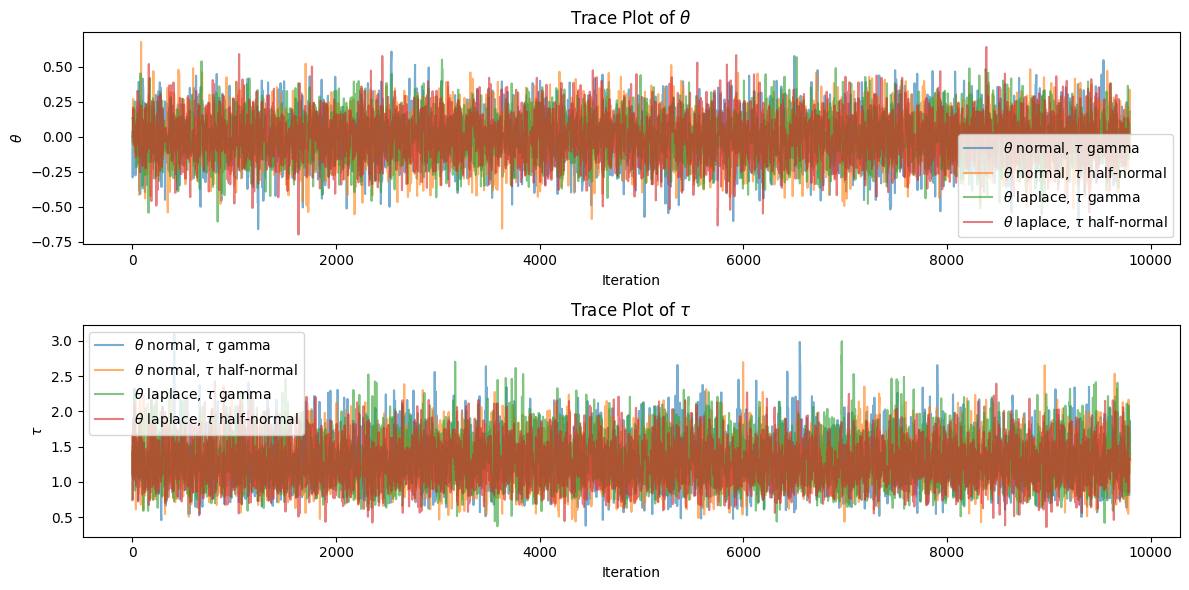

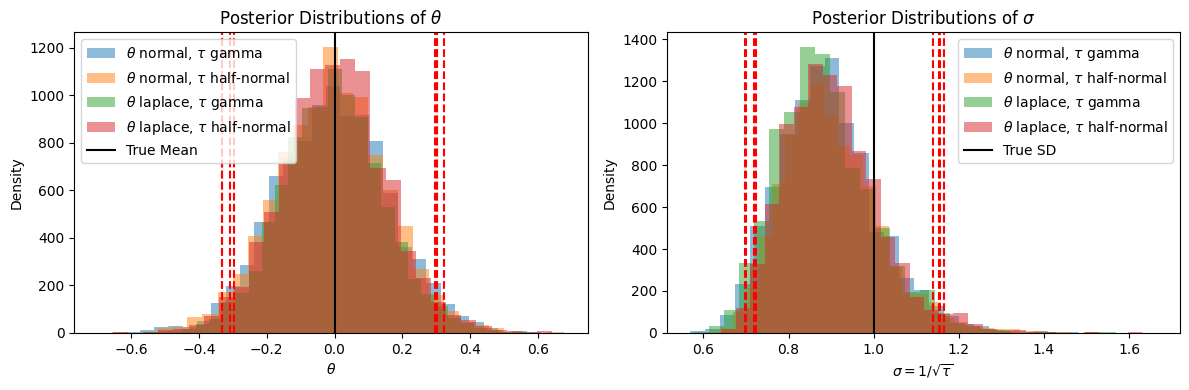

Theta credible interval ('normal', 'gamma'): [-0.33212267  0.3210785 ]
Theta credible interval ('normal', 'half-normal'): [-0.3318032   0.30150816]
Theta credible interval ('laplace', 'gamma'): [-0.29732735  0.29640178]
Theta credible interval ('laplace', 'half-normal'): [-0.30883889  0.30049955]
Sigma credible interval ('normal', 'gamma'): [0.69774918 1.15403333]
Sigma credible interval ('normal', 'half-normal'): [0.71962416 1.15620426]
Sigma credible interval ('laplace', 'gamma'): [0.69948266 1.13969073]
Sigma credible interval ('laplace', 'half-normal'): [0.72471798 1.16614602]


In [21]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Set parameters
n = 30
m = 0  # True mean
s = 1  # True standard deviation
np.random.seed(365)
x = stats.norm(loc=m, scale=s).rvs(size=n)

C, G = 2, 10000  # Chains and iterations
alpha, lambda_ = 2, 2  # Hyperparameters for Gamma prior

# Proposal standard deviations
theta_proposal_sd = 0.5  
tau_proposal_sd = 0.1  

# Different priors to compare
theta_priors = ['normal', 'laplace']
tau_priors = ['gamma', 'half-normal']

# Store results
theta_samples = {}
tau_samples = {}

# Run Metropolis within Gibbs for each prior combination
for theta_prior in theta_priors:
    for tau_prior in tau_priors:
        theta = np.zeros((C, G))
        tau = np.zeros((C, G))
        theta[:, 0] = np.mean(x)
        tau[:, 0] = 1 / np.var(x)

        for c in range(C):
            for g in range(1, G):
                # Metropolis step for theta
                theta_candidate = stats.norm(loc=theta[c, g - 1], scale=theta_proposal_sd).rvs()
                
                if theta_prior == 'normal':
                    log_prior_theta_current = stats.norm.logpdf(theta[c, g - 1], loc=0, scale=1)
                    log_prior_theta_candidate = stats.norm.logpdf(theta_candidate, loc=0, scale=1)
                elif theta_prior == 'laplace':
                    log_prior_theta_current = stats.laplace.logpdf(theta[c, g - 1], loc=0, scale=1)
                    log_prior_theta_candidate = stats.laplace.logpdf(theta_candidate, loc=0, scale=1)

                log_posterior_current = (
                    np.sum(stats.norm.logpdf(x, loc=theta[c, g - 1], scale=1 / np.sqrt(tau[c, g - 1])))
                    + log_prior_theta_current
                )
                log_posterior_candidate = (
                    np.sum(stats.norm.logpdf(x, loc=theta_candidate, scale=1 / np.sqrt(tau[c, g - 1])))
                    + log_prior_theta_candidate
                )

                log_alpha = log_posterior_candidate - log_posterior_current
                if np.log(np.random.rand()) < log_alpha:
                    theta[c, g] = theta_candidate
                else:
                    theta[c, g] = theta[c, g - 1]

                # Metropolis step for tau using truncated normal proposal
                tau_t_minus_1 = tau[c, g - 1]
                tau_candidate = stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf, loc=tau_t_minus_1, scale=s).rvs()

                if tau_prior == 'gamma':
                    log_prior_tau_current = stats.gamma.logpdf(tau[c, g - 1], a=alpha/2, scale=2/lambda_)
                    log_prior_tau_candidate = stats.gamma.logpdf(tau_candidate, a=alpha/2, scale=2/lambda_)
                elif tau_prior == 'half-normal':
                    log_prior_tau_current = stats.halfnorm.logpdf(tau[c, g - 1], loc=0, scale=1)
                    log_prior_tau_candidate = stats.halfnorm.logpdf(tau_candidate, loc=0, scale=1)

                log_posterior_current = (
                    np.sum(stats.norm.logpdf(x, loc=theta[c, g], scale=1 / np.sqrt(tau[c, g - 1])))
                    + log_prior_tau_current
                )
                log_posterior_candidate = (
                    np.sum(stats.norm.logpdf(x, loc=theta[c, g], scale=1 / np.sqrt(tau_candidate)))
                    + log_prior_tau_candidate
                )

                log_alpha = log_posterior_candidate - log_posterior_current
                if np.log(np.random.rand()) < log_alpha:
                    tau[c, g] = tau_candidate
                else:
                    tau[c, g] = tau[c, g - 1]

        # Store posterior samples after burn-in
        burn = 200
        theta_samples[(theta_prior, tau_prior)] = theta[0, burn:]
        tau_samples[(theta_prior, tau_prior)] = tau[0, burn:]

# Convert tau to standard deviation (sigma)
sigma_samples = {key: 1 / np.sqrt(val) for key, val in tau_samples.items()}

# Compute Bayesian credible intervals
theta_ci = {key: np.quantile(val, [0.025, 0.975]) for key, val in theta_samples.items()}
sigma_ci = {key: np.quantile(val, [0.025, 0.975]) for key, val in sigma_samples.items()}

# Plot overlaid trace plots
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Trace plot for theta
for (theta_prior, tau_prior), samples in theta_samples.items():
    ax[0].plot(samples, alpha=0.6, label=f"$\\theta$ {theta_prior}, $\\tau$ {tau_prior}")
ax[0].set_title("Trace Plot of $\\theta$")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("$\\theta$")
ax[0].legend()

# Trace plot for tau
for (theta_prior, tau_prior), samples in tau_samples.items():
    ax[1].plot(samples, alpha=0.6, label=f"$\\theta$ {theta_prior}, $\\tau$ {tau_prior}")
ax[1].set_title("Trace Plot of $\\tau$")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("$\\tau$")
ax[1].legend()

plt.tight_layout()
plt.show()

# Overlaid histograms of posterior distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Overlay histograms for theta
for (theta_prior, tau_prior), samples in theta_samples.items():
    ax[0].hist(samples, bins=30, alpha=0.5, label=f"$\\theta$ {theta_prior}, $\\tau$ {tau_prior}")
ax[0].axvline(m, color='black', linestyle='solid', label="True Mean")
for (theta_prior, tau_prior), ci in theta_ci.items():
    ax[0].axvline(ci[0], color='red', linestyle='dashed')
    ax[0].axvline(ci[1], color='red', linestyle='dashed')
ax[0].set_title("Posterior Distributions of $\\theta$")
ax[0].set_xlabel("$\\theta$")
ax[0].set_ylabel("Density")
ax[0].legend()

# Overlay histograms for sigma
for (theta_prior, tau_prior), samples in sigma_samples.items():
    ax[1].hist(samples, bins=30, alpha=0.5, label=f"$\\theta$ {theta_prior}, $\\tau$ {tau_prior}")
ax[1].axvline(s, color='black', linestyle='solid', label="True SD")
for (theta_prior, tau_prior), ci in sigma_ci.items():
    ax[1].axvline(ci[0], color='red', linestyle='dashed')
    ax[1].axvline(ci[1], color='red', linestyle='dashed')
ax[1].set_title("Posterior Distributions of $\\sigma$")
ax[1].set_xlabel("$\\sigma = 1 / \\sqrt{\\tau}$")
ax[1].set_ylabel("Density")
ax[1].legend()

plt.tight_layout()
plt.show()

# Print credible intervals
for key, ci in theta_ci.items():
    print(f"Theta credible interval {key}:", ci)
for key, ci in sigma_ci.items():
    print(f"Sigma credible interval {key}:", ci)

With Metropolis-Hastings, we no longer need to analytically derived full conditional distributions, which makes it more flexible than just Gibbs sampling, which requres full conditionals to be known. When conjugate prior exist, Gibbs ampling is more efficient since it guarantees acceptance, but when full conditionals are difficult to derive, MH is more useful. 

### Question 3

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$


![title](img/hw4_q3.png)